In [1]:
from ktools.utils.load_dataframes import load_all_dataframes
from ktools.modelling.ensemble.ridge_regression_blending_ensemble import RidgeRegressionBlendingEnsemble

 __  ___ .___________.  ______     ______    __          _______.
|  |/  / |           | /  __  \   /  __  \  |  |        /       |
|  '  /  `---|  |----`|  |  |  | |  |  |  | |  |       |   (----`
|    <       |  |     |  |  |  | |  |  |  | |  |        \   \    
|  .  \      |  |     |  `--'  | |  `--'  | |  `----.----)   |   
|__|\__\     |__|      \______/   \______/  |_______|_______/    
                                                                 



In [2]:
oofs = load_all_dataframes("./data/diabetes_prediction/oofs/")
test_preds = load_all_dataframes("./data/diabetes_prediction/test_preds/")

In [3]:
import pandas as pd
from sklearn.metrics import roc_auc_score


def plot_test_dist_performance_against_nontest(oofs: pd.DataFrame, test_preds: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    auc_tests = []
    auc_trains = []

    for model_name in test_preds.columns:

        true_labels_test = oofs.loc[oofs["data"] == 0, 'diagnosed_diabetes']
        true_labels_train = oofs.loc[oofs["data"] == 1, 'diagnosed_diabetes']

        oof_preds_train = oofs.loc[oofs["data"] == 1, model_name]
        oof_preds_test = oofs.loc[oofs["data"] == 0, model_name]

        auc_test = roc_auc_score(true_labels_test, oof_preds_test)
        # print(f'ROC AUC Score for {model_name}: {auc_test:.4f}')
        auc_train = roc_auc_score(true_labels_train, oof_preds_train)
        # print(f'ROC AUC Score for {model_name}: {auc_train:.4f}')

        auc_tests.append(auc_test)
        auc_trains.append(auc_train)

    plt.figure(figsize=(12, 6))
    plt.scatter(auc_trains, auc_tests)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Train-like OOF ROC AUC')
    plt.ylabel('Test-like OOF ROC AUC')
    plt.title('Train vs Test ROC AUC Scores')
    plt.grid()
    plt.show()

In [4]:
# plot_test_dist_performance_against_nontest(oofs, test_preds)

In [5]:
oofs = oofs[oofs["data"] == 0]

In [6]:
oofs.drop(columns=[f for f in oofs.columns if f.endswith("BAG_L1")], inplace=True)
test_preds.drop(columns=[f for f in test_preds.columns if f.endswith("BAG_L1")], inplace=True)

In [7]:
for model in test_preds.columns:
    predictions = oofs[model]
    auc = roc_auc_score(oofs["diagnosed_diabetes"], predictions)
    print(f"{model}: ROC AUC = {auc:.4f}")

LightGBMXT_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7029
LightGBM_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7037
RandomForestGini_BAG_L1_with_orig_encoded_features: ROC AUC = 0.6956
RandomForestEntr_BAG_L1_with_orig_encoded_features: ROC AUC = 0.6957
CatBoost_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7041
ExtraTreesGini_BAG_L1_with_orig_encoded_features: ROC AUC = 0.6964
ExtraTreesEntr_BAG_L1_with_orig_encoded_features: ROC AUC = 0.6964
NeuralNetFastAI_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7015
XGBoost_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7009
NeuralNetTorch_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7012
LightGBMLarge_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7027
CatBoost_r177_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7043
NeuralNetTorch_r79_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7008
LightGBM_r131_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7036
NeuralNetFastAI_r191_BAG_L1_with_orig_encoded_features: ROC AUC = 0.7012
CatBoo

####################################################################################################
<function roc_auc_score at 0xffff0b1eee80>  score of ridge blender:  0.7081736649323731
####################################################################################################


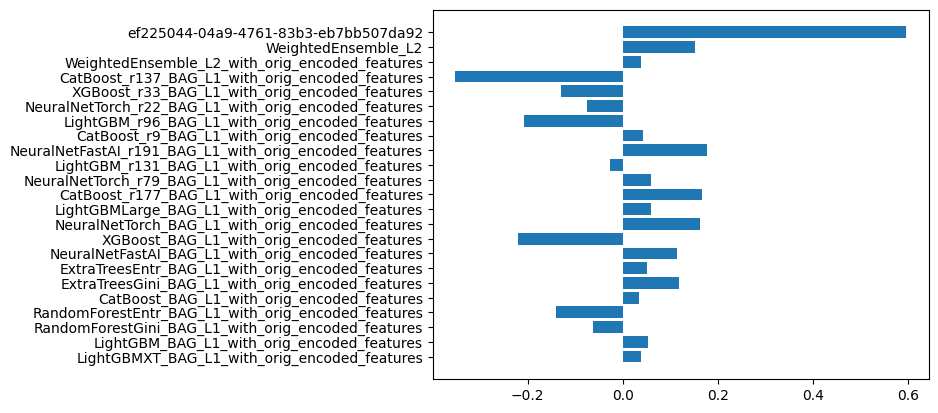

,predictor_name,score
0,CatBoost_r137_BAG_L1_with_orig_encoded_features,-0.352505
1,XGBoost_BAG_L1_with_orig_encoded_features,-0.220792
2,LightGBM_r96_BAG_L1_with_orig_encoded_features,-0.207267
3,RandomForestEntr_BAG_L1_with_orig_encoded_features,-0.139829
4,XGBoost_r33_BAG_L1_with_orig_encoded_features,-0.130853
5,NeuralNetTorch_r22_BAG_L1_with_orig_encoded_features,-0.075429
6,RandomForestGini_BAG_L1_with_orig_encoded_features,-0.062509
7,LightGBM_r131_BAG_L1_with_orig_encoded_features,-0.027700
8,CatBoost_BAG_L1_with_orig_encoded_features,0.035249
9,LightGBMXT_BAG_L1_with_orig_encoded_features,0.037901


In [25]:
from sklearn.metrics import roc_auc_score


ensemble = RidgeRegressionBlendingEnsemble(
    oof_dataframe=oofs[test_preds.columns],
    train_labels=oofs["diagnosed_diabetes"],
    metric=roc_auc_score,
)

ensemble.fit_weights()

In [26]:
final_test_preds = ensemble.predict(test_preds)

In [27]:
import pandas as pd
from datetime import datetime

sub_name = f"submissions/ridge_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
sample_sub = pd.read_csv("data/diabetes_prediction/sample_submission.csv", index_col=0)
sample_sub["diagnosed_diabetes"] = final_test_preds
sample_sub.to_csv(sub_name)

In [30]:
test_preds = pd.read_csv("/workspaces/Kaggle-tools/data/diabetes_prediction/test_preds/test_preds_ef225044-04a9-4761-83b3-eb7bb507da92.csv", index_col=0)

In [41]:
sample_sub = pd.read_csv("data/diabetes_prediction/sample_submission.csv", index_col=0)
sample_sub["diagnosed_diabetes"] = test_preds.to_numpy()
sample_sub.to_csv("flaml_test_pred.csv")

In [42]:
sample_sub

,diagnosed_diabetes
id,
700000,0.478823
700001,0.680082
700002,0.780292
700003,0.413262
700004,0.915138
...,...
999995,0.782395
999996,0.688727
999997,0.644392
